In [1]:
'''Kaggle competition for House Prices in Ames, Iowa.
https://www.kaggle.com/c/house-prices-advanced-regression-techniques'''
   
__author__ = 'Mike DiPalma'
__email__ = 'mdipalma78@gmail.com'

### Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVR
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor

from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from math import sqrt

### Define Data Class

In [3]:
class Data:
    def __init__(self, train_file, test_file, cat_cols, num_cols, target_col, id_col, trans_cols, group_cols, \
                 engineer_features, one_hot_encode):
        '''create train and test dataframe'''
        #create new copies instead of references
        self.cat_cols = list(cat_cols)
        self.num_cols = list(num_cols)
        self.group_cols = list(group_cols)
        self.feature_cols = cat_cols + num_cols
        self.target_col = target_col
        self.id_col = id_col
        self.label_encoders = {}
        self.train_df, self.test_df, self.test_Id, self.comb_df, self.feature_cols = self._create_df(train_file, test_file, cat_cols, \
                                                                                  num_cols, target_col, id_col, \
                                                                                  trans_cols, group_cols, \
                                                                                  engineer_features, one_hot_encode)

    def _create_df(self, train_file, test_file, cat_cols, num_cols, target_col, id_col, trans_cols, group_cols, \
                   engineer_features=False, one_hot_encode=False):
        '''loads training and test data, combines, preprocesses, encodes and seperates data into df for modeling'''
        train_df = self._load_data(train_file)
        test_df = self._load_data(test_file)
        # Save the test ID columnn for the submission file
        test_Id = test_df['Id']
        train_df = self._clean_data(train_df)
        train_df = self._shuffle_data(train_df)
        comb_df = self._combine_data(train_df, test_df)
        comb_df = self._transform_data_types(comb_df, trans_cols)
        comb_df = self._fill_NaN(comb_df, num_cols, cat_cols)
        print("Engineer Features: ", engineer_features)
        if engineer_features:
            comb_df = self.aggregate_features(comb_df)
            comb_df = self.add_group_stats(comb_df)
        print("One-hot Encode: ", one_hot_encode)
        if one_hot_encode:
            comb_df = self._one_hot_encode_df(comb_df, self.cat_cols, self.num_cols, target_col)
        train_df = comb_df[comb_df['log1pSalePrice'].notnull()]
        feature_cols = comb_df.drop(['log1pSalePrice'], axis=1).columns
        test_df = comb_df[comb_df['log1pSalePrice'].isnull()]
        test_df = test_df.drop(['log1pSalePrice'], axis=1)
        return train_df, test_df, test_Id, comb_df, feature_cols

    def _create_test_df(self, test_file, label_encode=True):
        '''loads and label encodes test data'''
        test_df = self._load_data(test_file)
        if label_encode:
            self.one_hot_encode_df(test_df, self.cat_cols)
        return test_df
        
    def _load_data(self, file):
        '''loads csv to pd dataframe'''
        return pd.read_csv(file)
    
    def _combine_data(self, train, test):    
        '''Joins train and test dataframes and resets the index'''
        comb_df = pd.concat([train, test], sort=False)
        comb_df = comb_df.reset_index(drop=True) # reset index
        return comb_df

    def _transform_data_types(self, df, cols):
        '''Converts number fields which should be strings'''
        for col in cols:
            df[col] = df[col].apply(str)
        return df
    
    def _fill_NaN(self, df, num_cols, cat_cols):
        ''' replaces Nan values based on data type'''
        for col in (num_cols):
            df[col].fillna(0.0, inplace=True)
        for col in (cat_cols):
            df[col].fillna('None', inplace=True)
        return df

    def _one_hot_encode_df(self, df, cat_cols=None, num_cols=None, tar_col=None):
        '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
        cat_df = pd.get_dummies(df[cat_cols], drop_first=True)
        num_df = df[num_cols].apply(pd.to_numeric)
        tar_df = df[tar_col].apply(pd.to_numeric)
        return pd.concat([cat_df, num_df, tar_df], axis=1)#,ignore_index=False)
   
    def _clean_data(self, df):
        '''removes outliers and applies log1p transformation to SalePrice'''
        df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
        df['log1pSalePrice'] = np.log1p(df['SalePrice'])
        df = df.drop(columns=['SalePrice'])
        return df

    def _shuffle_data(self, df):
        return shuffle(df).reset_index(drop=True)        
    
    def aggregate_features(self, df):
        '''Combines the values of numeric features'''
        df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
        df['TotalBath'] = df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath'])
        # update column lists
        agg_cols = ['TotalSF', 'TotalBath']
        self._extend_col_lists(num_cols=agg_cols)
        return df

    def _get_group_stats(self, df):
        '''calculates group statistics'''
        target_col = self.target_col
        group_stats_df = pd.DataFrame({'group_mean': df.groupby(group_cols)[target_col].mean()})
        group_stats_df['group_max'] = df.groupby(group_cols)[target_col].max()
        group_stats_df['group_min'] = df.groupby(group_cols)[target_col].min()
        group_stats_df['group_std'] = df.groupby(group_cols)[target_col].std()
        group_stats_df['group_median'] = df.groupby(group_cols)[target_col].median()
        group_stats_df.fillna(0, inplace=True)
        return group_stats_df
        
    def add_group_stats(self, df):
        '''adds group statistics to data stored in data object'''
        #get group stats
        group_stats_df = self._get_group_stats(df)
        group_stats_df.reset_index(inplace=True)
  
        #merge derived columns to original df
        df = self._merge_new_cols(df, group_stats_df, self.group_cols, fillna=False)
        
        #update column lists
        group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
        self._extend_col_lists(num_cols=group_stats_cols)  
        return df
    
    def _merge_new_cols(self, df, new_cols_df, keys, fillna=False):
        '''merges engineered features with original df'''
        df = pd.merge(df, new_cols_df, on=keys, how='left')
        if fillna:
            df.fillna(0, inplace=True)
        return df
        
    def _extend_col_lists(self, cat_cols=[], num_cols=[]):
        '''addes engineered feature cols to data col lists'''
        self.num_cols.extend(num_cols)
        self.cat_cols.extend(cat_cols)
        self.feature_cols.extend(num_cols + cat_cols)
        

### Define Model Class

In [4]:
class ModelContainer:
    def __init__(self, models=[]):#, default_num_iters=10, verbose_lvl=0):
        '''initializes model list and dicts'''
        self.models = models
        self.best_model = None
        self.predictions = None
        self.mean_rmse = {}
        self.cv_std = {}
        #self.default_num_iters = default_num_iters
        #self.verbose_lvl = verbose_lvl
        
    def add_model(self, model):
        self.models.append(model)
        print(model)

    def cross_validate(self, data, k=3, num_procs=1):
        '''cross validate models using given data'''
        # set table to table to populate with performance results
        rmse_results = []
        names = []
        col = ['Algorithm', 'RMSE Mean', 'RMSE SD']
        results_df = pd.DataFrame(columns=col)
        i = 0

        feature_df = data.train_df[data.feature_cols]
        target_df = data.train_df[data.target_col]
        for name, model in self.models:
            print(name, model)
            print("Evaluating {}...".format(name))
            neg_mse = cross_val_score(model, feature_df, target_df, cv=k, n_jobs=num_procs, scoring='neg_mean_squared_error')
            cv_rmse_results = np.sqrt(-neg_mse)
            self.mean_rmse[model] = np.mean(cv_rmse_results)
            self.cv_std[model] = np.std(cv_rmse_results)
            rmse_results.append(cv_rmse_results)
            names.append(name)
            results_df.loc[i] = [name,
                                 round(cv_rmse_results.mean(), 4),
                                 round(cv_rmse_results.std(), 4)]
            i += 1
        results_df = results_df.sort_values(by=['RMSE Mean'], ascending=True).reset_index(drop=True)
        print(results_df)
    
    def select_best_model(self):
        '''select model with lowest mse'''
        self.best_model = min(self.mean_rmse, key=self.mean_rmse.get)
        
    def best_model_fit(self, features, targets):
        '''fits best model'''
        self.best_model.fit(features, targets)
    
    def best_model_predict(self, features):
        '''scores features using best model'''
        self.predictions = self.best_model.predict(features)
        self.predictions = np.expm1(self.predictions)

        
    def save_results(self, model, mean_mse, predictions):
        '''saves model, model summary, feature importances, and predictions'''
        with open('model.txt', 'w') as file:
            file.write(str(model))
        np.savetxt('predictions.csv', predictions, delimiter=',')
        #create_submission(test_df, test_ID, predictions)
   
    @staticmethod
    def get_feature_importance(model, cols):
        '''retrieves and sorts feature importances'''
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importances = pd.DataFrame({'feature':cols, 'importance':importances})
            feature_importances.sort_values(by='importance', ascending=False, inplace=True)
            #set index to 'feature'
            feature_importances.set_index('feature', inplace=True, drop=True)
            return feature_importances[0:25]
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"

    def print_summary(self):
        '''prints summary of models, best model, and feature importance'''
        print('\nModel Summaries:\n')
        for model in models.mean_rmse:
            print('\n', model, '\n', 'RMSE:', models.mean_rmse[model])
            print('\n', 'Standard deviation during CV:\n', models.cv_std[model])
        print('\nBest Model:\n', models.best_model)
        print('\nMSE of Best Model\n', models.mean_rmse[models.best_model])
        print('\nFeature Importances\n', models.get_feature_importance(models.best_model, data.feature_cols))
        #save results
        print('Saving results.')
        self.save_results(model, models.mean_rmse[model], self.predictions)
        print('Creating submission file.')
        self.create_submission(data.test_df, data.test_Id, self.predictions)
        if hasattr(model, 'feature_importances_'):
            feature_importances = self.get_feature_importance(models.best_model, data.feature_cols)
            feature_importances[0:25].plot.bar(figsize=(20,10))
            plt.show()
        else:
            #some models don't have feature_importances_
            return "Feature importances do not exist for given model"
        
    def create_submission(self, test_df, test_ID, predictions):
        sub_df = pd.DataFrame({'Id': test_ID.values.tolist(), 'SalePrice': pd.Series(models.predictions, index=test_df.index)})

        timestr = time.strftime("%Y%m%d-%H%M%S") 

        sub_df.to_csv('submission-' + timestr + '.csv', index=False)

### Define parameters needed to create and run models

In [5]:
# define number of CV folds
k = 5

# define number of processors to use for parallel runs
num_procs = 4

# set verbose level for models
verbose_lvl = 0

# Define inputs
train_file = 'data/train.csv'
test_file = 'data/test.csv'

# Define variables
cat_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', \
            'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', \
            'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', \
            'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', \
            'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', \
            'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', \
            'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'] 
num_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', \
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', \
            'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', \
            'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
target_col = 'log1pSalePrice'
id_col = 'Id'
transform_cols = ['MSSubClass', 'MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', \
                  'OverallQual', 'OverallCond']
group_cols = ['OverallQual']
#group_cols = ['OverallQual', 'Neighborhood', 'YearBuilt', 'ExterQual', 'BsmtQual', 'GarageYrBlt', 'KitchenQual', \
#              'GarageFinish', 'YearRemodAdd', 'GarageType']
# Turn feature engineering on/off
engineer_features = True

# Turn one-hot encoding on/off
one_hot_encode = True

### Create Data Object

In [6]:
data = Data(train_file, test_file, cat_cols, num_cols, target_col, id_col, transform_cols, group_cols, engineer_features, one_hot_encode)

Engineer Features:  True
One-hot Encode:  True


### Create model container and add models to it

In [7]:
#create model container
models = ModelContainer()

lr = LinearRegression()
ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=60, n_jobs=num_procs, max_depth=15, min_samples_split=80, \
                           max_features=8, verbose=verbose_lvl)
gbr = GradientBoostingRegressor(n_estimators=80, max_depth=7, loss='ls', verbose=verbose_lvl)
sr = StackingRegressor(regressors=(lr, ridge, rf, gbr), \
                       meta_regressor=ridge, \
                       use_features_in_secondary=False)
svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003)
lightgbm = LGBMRegressor(objective='regression', 
                         num_leaves=6,
                         learning_rate=0.01, 
                         n_estimators=7000,
                         max_bin=200, 
                         bagging_fraction=0.8,
                         bagging_freq=4, 
                         bagging_seed=8,
                         feature_fraction=0.2,
                         feature_fraction_seed=8,
                         min_sum_hessian_in_leaf = 11,
                         verbose=-1,
                         random_state=42)


#add models to model container
models.add_model(('Linear Regression', lr))
models.add_model(('Ridge Regression', ridge))
models.add_model(('Random Forest', rf))
models.add_model(('Gradient Boosting Regressor', gbr))
models.add_model(('Stacking Regressor', sr))
models.add_model(('Support Vector Regressor', svr))
models.add_model(('Light GBM', lightgbm))


('Linear Regression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))
('Ridge Regression', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001))
('Random Forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=80,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False))
('Gradient Boosting Regressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          mi

### Create ensemble stack 

In [8]:
stack_gen = StackingCVRegressor(regressors=(lr, ridge, rf, gbr), \
                                meta_regressor=ridge, \
                                use_features_in_secondary=False)

In [9]:
stack_gen

StackingCVRegressor(cv=5,
                    meta_regressor=Ridge(alpha=1.0, copy_X=True,
                                         fit_intercept=True, max_iter=None,
                                         normalize=False, random_state=None,
                                         solver='auto', tol=0.001),
                    n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
                    refit=True,
                    regressors=(LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                                Ridge(alpha=1.0, copy_X=True,
                                      fit_inte...
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
          

In [10]:
stack_gen_model = stack_gen.fit(np.array(data.train_df[data.feature_cols]), np.array(data.train_df[data.target_col]))

In [11]:
stack_gen_model

StackingCVRegressor(cv=5,
                    meta_regressor=Ridge(alpha=1.0, copy_X=True,
                                         fit_intercept=True, max_iter=None,
                                         normalize=False, random_state=None,
                                         solver='auto', tol=0.001),
                    n_jobs=None, pre_dispatch='2*n_jobs', random_state=None,
                    refit=True,
                    regressors=(LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                                Ridge(alpha=1.0, copy_X=True,
                                      fit_inte...
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
          

### Cross validate models, then select, fit, and score test data with best model

In [12]:
models.cross_validate(data, k, num_procs=num_procs)
models.select_best_model()
models.best_model_fit(data.train_df[data.feature_cols], data.train_df[data.target_col])
models.best_model_predict(data.test_df[data.feature_cols])
#models.save_results(models.best_model, models.predictions, models.feature_importances)

Linear Regression LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Evaluating Linear Regression...
Ridge Regression Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Evaluating Ridge Regression...
Random Forest RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=80,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)
Evaluating Random Forest...
Gradient Boosting Regressor GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                      

### Summarize results


Model Summaries:


 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) 
 RMSE: 214.75639404483871

 Standard deviation during CV:
 269.06799130877795

 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) 
 RMSE: 0.12967115361840767

 Standard deviation during CV:
 0.006180206892134598

 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=80,
                      min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False) 
 RMSE: 0.1993116178122114

 Standard deviation during CV:
 0.0066366547721243094

 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', 

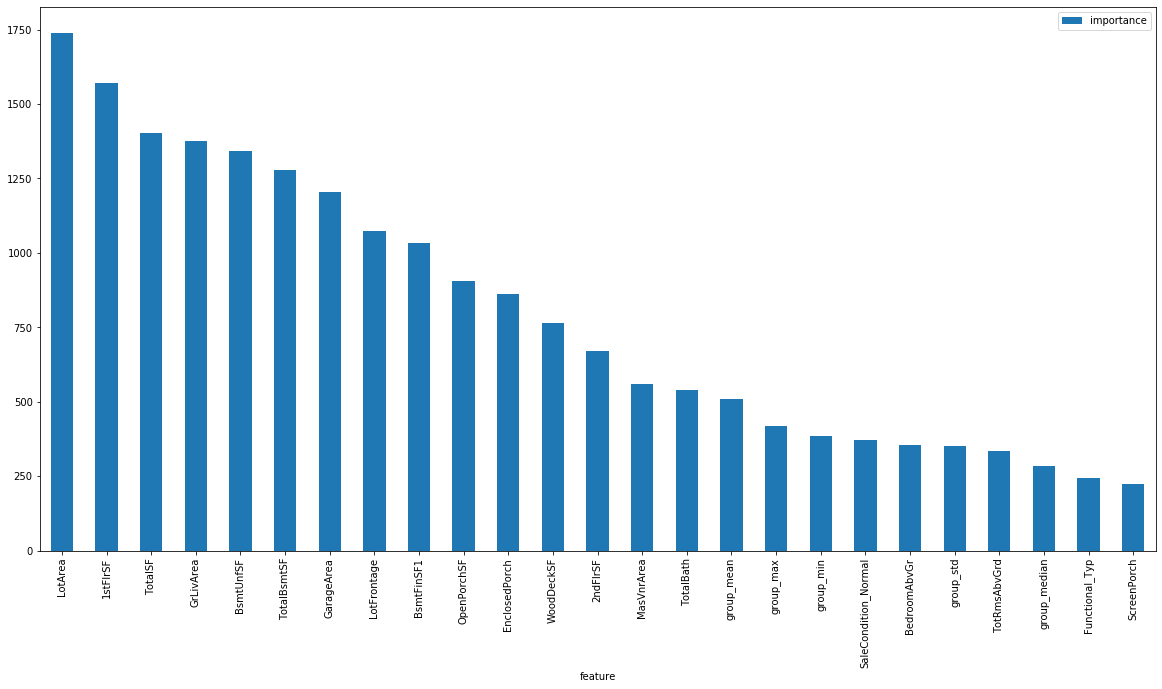

In [13]:
models.print_summary()